In [54]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import random

In [55]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

In [56]:
EXPERIMENT_NAME         = "test"
DATASET                 = "training" #needs to have a subfolder which contains the data
START_TRAIN_AT_IMG_SIZE = 4
DEVICE                  = "cuda" if torch.cuda.is_available() else "mps"
LEARNING_RATE           = 1e-3
BATCH_SIZES             = [32, 32, 32, 16, 16, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
image_size              = 128
CHANNELS_IMG            = 3
Z_DIM                   = 256  # should be 512 in original paper
IN_CHANNELS             = 256  # should be 512 in original paper
LAMBDA_GP               = 10
PROGRESSIVE_EPOCHS      = [30] * len(BATCH_SIZES)

LOAD_MODEL              = False
SAVED_PATH              = "outputs/test_75_training_128x128/"
EPISODE_SIZE            = 16

In [57]:
amount_folders = len([name for name in os.listdir('outputs') if os.path.isdir(os.path.join('outputs', name))])

EXPERIMENT_NAME = f"{EXPERIMENT_NAME}_{amount_folders}_{DATASET}_{image_size}x{image_size}"
print(EXPERIMENT_NAME)

OUTPUT_DIR = f'outputs/{EXPERIMENT_NAME}'

test_95_training_128x128


In [58]:
!pwd

/workspaces/12_GAI_GANkomon


In [59]:
def get_loader(image_size):
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = dset.ImageFolder(root=f"dataset/{DATASET}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
    return dataloader, dataset

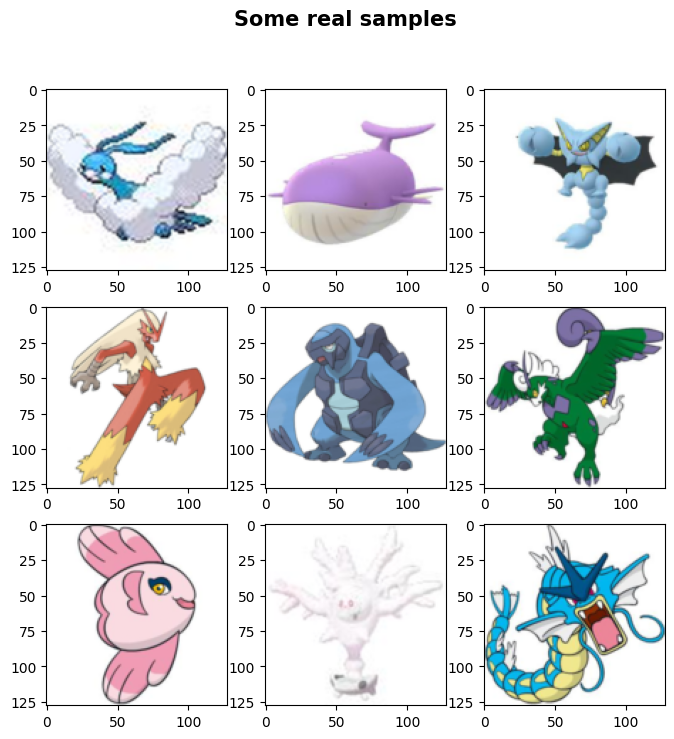

In [60]:
def check_loader():
    loader,_ = get_loader(128)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
check_loader()

In [61]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [62]:
class WSConv2d(nn.Module):

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
    ):
        super(WSConv2d, self).__init__()
        self.conv      = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale     = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias      = self.conv.bias #Copy the bias of the current column layer
        self.conv.bias = None      #Remove the bias

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [63]:
class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

In [64]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1  = WSConv2d(in_channels, out_channels)
        self.conv2  = WSConv2d(out_channels, out_channels)
        self.leaky  = nn.LeakyReLU(0.2)
        self.pn     = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [65]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

In [66]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [67]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="mps"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [68]:
def generate_examples(gen, steps, n=100, path='saved_examples'):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(os.path.join(path,f'step{steps}')):
                os.makedirs(os.path.join(path,f'step{steps}'))
            save_image(img*0.5+0.5, os.path.join(path,f"step{steps}/img_{i}.png"))
    gen.train()

In [69]:
torch.backends.cudnn.benchmarks = True

In [70]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001 * torch.mean(critic_real ** 2))
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )
        

    return alpha


In [71]:
# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

critic = Discriminator(
    IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

if LOAD_MODEL:
    gen.load_state_dict(torch.load(SAVED_PATH + f'generator_{EPISODE_SIZE}.pth'))
    critic.load_state_dict(torch.load(SAVED_PATH + f'critic_{EPISODE_SIZE}.pth'))

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)


gen.train()
critic.train()

os.makedirs(f'outputs/{EXPERIMENT_NAME}', exist_ok=True)

step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS:
    alpha = 1e-5  # start with very low alpha, you can start with alpha=0
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
        )
    generate_examples(gen, step, n=100, path=f'outputs/{EXPERIMENT_NAME}')

    # Assuming that `gen` is your Generator instance
    torch.save(gen.state_dict(), f'outputs/{EXPERIMENT_NAME}/generator_{4 * 2 ** step}.pth')
    torch.save(critic.state_dict(), f'outputs/{EXPERIMENT_NAME}/critic_{4 * 2 ** step}.pth')

    step += 1  # progress to the next img size

Current image size: 4
Epoch [1/30]


100%|██████████| 230/230 [00:10<00:00, 22.33it/s, gp=0.0182, loss_critic=-0.686] 


Epoch [2/30]


100%|██████████| 230/230 [00:10<00:00, 21.59it/s, gp=0.0135, loss_critic=-0.274]  


Epoch [3/30]


100%|██████████| 230/230 [00:10<00:00, 21.79it/s, gp=0.00553, loss_critic=-0.28]  


Epoch [4/30]


100%|██████████| 230/230 [00:10<00:00, 21.76it/s, gp=0.0081, loss_critic=-0.194]  


Epoch [5/30]


100%|██████████| 230/230 [00:10<00:00, 22.48it/s, gp=0.00915, loss_critic=-0.17]   


Epoch [6/30]


100%|██████████| 230/230 [00:10<00:00, 22.25it/s, gp=0.00459, loss_critic=-0.14]   


Epoch [7/30]


100%|██████████| 230/230 [00:10<00:00, 21.95it/s, gp=0.00462, loss_critic=-0.183]   


Epoch [8/30]


100%|██████████| 230/230 [00:10<00:00, 22.07it/s, gp=0.00519, loss_critic=0.00492] 


Epoch [9/30]


100%|██████████| 230/230 [00:10<00:00, 22.19it/s, gp=0.00896, loss_critic=0.0465]   


Epoch [10/30]


100%|██████████| 230/230 [00:10<00:00, 22.07it/s, gp=0.00178, loss_critic=0.0109]   


Epoch [11/30]


100%|██████████| 230/230 [00:10<00:00, 22.46it/s, gp=0.0084, loss_critic=0.0507]   


Epoch [12/30]


100%|██████████| 230/230 [00:10<00:00, 21.81it/s, gp=0.00343, loss_critic=-0.0179]  


Epoch [13/30]


100%|██████████| 230/230 [00:10<00:00, 22.13it/s, gp=0.00494, loss_critic=-0.0781]  


Epoch [14/30]


100%|██████████| 230/230 [00:10<00:00, 21.98it/s, gp=0.00899, loss_critic=-0.0148]  


Epoch [15/30]


100%|██████████| 230/230 [00:10<00:00, 22.33it/s, gp=0.00571, loss_critic=0.0397]   


Epoch [16/30]


100%|██████████| 230/230 [00:10<00:00, 22.29it/s, gp=0.00811, loss_critic=0.0219]   


Epoch [17/30]


100%|██████████| 230/230 [00:10<00:00, 21.38it/s, gp=0.00354, loss_critic=0.0558]   


Epoch [18/30]


100%|██████████| 230/230 [00:10<00:00, 22.45it/s, gp=0.00301, loss_critic=-0.0255]  


Epoch [19/30]


100%|██████████| 230/230 [00:10<00:00, 21.56it/s, gp=0.0044, loss_critic=0.0255]    


Epoch [20/30]


100%|██████████| 230/230 [00:10<00:00, 22.13it/s, gp=0.00202, loss_critic=0.135]   


Epoch [21/30]


100%|██████████| 230/230 [00:10<00:00, 21.80it/s, gp=0.00543, loss_critic=0.0302]  


Epoch [22/30]


100%|██████████| 230/230 [00:10<00:00, 22.94it/s, gp=0.00376, loss_critic=0.0296]   


Epoch [23/30]


100%|██████████| 230/230 [00:10<00:00, 22.58it/s, gp=0.00393, loss_critic=0.0885]  


Epoch [24/30]


100%|██████████| 230/230 [00:10<00:00, 22.64it/s, gp=0.0035, loss_critic=0.0148]    


Epoch [25/30]


100%|██████████| 230/230 [00:10<00:00, 22.20it/s, gp=0.00321, loss_critic=0.0029]   


Epoch [26/30]


100%|██████████| 230/230 [00:10<00:00, 22.85it/s, gp=0.00661, loss_critic=0.102]   


Epoch [27/30]


100%|██████████| 230/230 [00:10<00:00, 22.64it/s, gp=0.00448, loss_critic=-0.0215]  


Epoch [28/30]


100%|██████████| 230/230 [00:10<00:00, 22.38it/s, gp=0.00636, loss_critic=-0.00459] 


Epoch [29/30]


100%|██████████| 230/230 [00:10<00:00, 22.10it/s, gp=0.0024, loss_critic=0.0467]   


Epoch [30/30]


100%|██████████| 230/230 [00:10<00:00, 22.47it/s, gp=0.00681, loss_critic=0.0317]  


Current image size: 8
Epoch [1/30]


100%|██████████| 230/230 [00:10<00:00, 21.33it/s, gp=0.00353, loss_critic=0.295]    


Epoch [2/30]


100%|██████████| 230/230 [00:10<00:00, 21.96it/s, gp=0.00294, loss_critic=-0.0837] 


Epoch [3/30]


100%|██████████| 230/230 [00:11<00:00, 20.74it/s, gp=0.00468, loss_critic=-0.163]   


Epoch [4/30]


100%|██████████| 230/230 [00:10<00:00, 22.02it/s, gp=0.00541, loss_critic=-0.108]   


Epoch [5/30]


100%|██████████| 230/230 [00:10<00:00, 22.27it/s, gp=0.00413, loss_critic=-0.0934]  


Epoch [6/30]


100%|██████████| 230/230 [00:10<00:00, 21.93it/s, gp=0.0028, loss_critic=0.16]     


Epoch [7/30]


100%|██████████| 230/230 [00:10<00:00, 22.04it/s, gp=0.008, loss_critic=-0.229]    


Epoch [8/30]


100%|██████████| 230/230 [00:10<00:00, 21.89it/s, gp=0.00176, loss_critic=0.25]    


Epoch [9/30]


100%|██████████| 230/230 [00:10<00:00, 21.75it/s, gp=0.00284, loss_critic=0.145]    


Epoch [10/30]


100%|██████████| 230/230 [00:10<00:00, 22.06it/s, gp=0.00358, loss_critic=-0.0335]  


Epoch [11/30]


100%|██████████| 230/230 [00:11<00:00, 20.82it/s, gp=0.00223, loss_critic=-0.0644] 


Epoch [12/30]


100%|██████████| 230/230 [00:11<00:00, 20.88it/s, gp=0.00233, loss_critic=0.0777]  


Epoch [13/30]


100%|██████████| 230/230 [00:10<00:00, 21.89it/s, gp=0.00365, loss_critic=0.0804]   


Epoch [14/30]


100%|██████████| 230/230 [00:10<00:00, 21.38it/s, gp=0.00325, loss_critic=-0.141]  


Epoch [15/30]


100%|██████████| 230/230 [00:10<00:00, 21.56it/s, gp=0.00191, loss_critic=0.0274]  


Epoch [16/30]


100%|██████████| 230/230 [00:10<00:00, 21.91it/s, gp=0.00629, loss_critic=0.0325] 


Epoch [17/30]


100%|██████████| 230/230 [00:11<00:00, 20.86it/s, gp=0.00402, loss_critic=-0.011]  


Epoch [18/30]


100%|██████████| 230/230 [00:10<00:00, 22.50it/s, gp=0.00459, loss_critic=-0.0197] 


Epoch [19/30]


 28%|██▊       | 64/230 [00:03<00:07, 20.99it/s, gp=0.0034, loss_critic=0.0246]   


KeyboardInterrupt: 